In [13]:
import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, merge
from keras.models import Model, Sequential
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from src.learning.processing import parse
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed as TD
BATCH_SIZE = 16
data_dir = "src/client/pictures1/"
data_save_dir = "datasets/npy/"
big_dir = "tawn_dataset/"

def normalize_label(old_val, old_min, old_max, new_min, new_max):
    old_val = float(old_val)
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

def padding_img_id(string_i):
    padding = 7 - len(string_i)
    for i in range(padding):
        string_i = "0" + string_i
    return string_i

### CAUTION flip only once !

In [37]:
image_paths = []
angle_labels = []
speed_labels = []
for root, dirs, files in os.walk(data_dir):
    nb_data = len(files)
    files = sorted(files)
    for file in files:
        if file.endswith(".jpg"):
            filename = os.path.join(root, file)
            image_paths.append(filename)
            s = filename.split("_")
            angle_labels.append(float(s[1]))
            speed_labels.append(float(s[2].rstrip(s[2][-4:])))
image_paths = np.array(image_paths)
angle_labels = np.array(angle_labels)
speed_labels = np.array(speed_labels)

In [38]:
angle_labels = ((angle_labels - 35) / 170.0 - 0.5) * 2
idx = 0
for spd in speed_labels:
    speed_labels[idx] = normalize_label(spd, 40, 102, 0, 1)
    idx += 1

In [39]:
(angle_labels.shape, speed_labels.shape, image_paths.shape)

((7728,), (7728,), (7728,))

In [40]:
from random import shuffle

def build_dataset(datas):
    dataset = np.zeros((datas.shape[0], 120, 160, 3))
    for i in range(datas.shape[0]):    
        img = cv2.imread(datas[i])
        y1 = int(img.shape[0] / 2)
        img = img[y1:, :]
        img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
        dataset[i, :, :, :] = img
    return dataset

def build_labels(datas):
    labels = np.array([data[1] for data in datas])
    return to_categorical(labels, 15)


def myGenerator(datas, angle_labels, speed_labels, batch=16):
    i = 0
    while (True):
        if (i == 0):
            loaded_img = build_dataset(datas[:batch])
        else:
            loaded_img = build_dataset(datas[(i - 2):(i + batch)])
        
        nb_batch = i
        x = np.zeros((batch, 3, 120, 160, 3))
        y = np.zeros((batch, 2))
        
        u = 0
        while (nb_batch < i + batch and nb_batch < datas.shape[0]):
            if (nb_batch == 0):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u]
                x[u, 2, :, :, :] = loaded_img[u]
            elif (nb_batch == 1):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u - 1]
                x[u, 2, :, :, :] = loaded_img[u - 1]
            elif (i == 0):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u - 1]
                x[u, 2, :, :, :] = loaded_img[u - 2]
            else:
                idx = u + 2
                x[u, 0, :, :, :] = loaded_img[idx]
                x[u, 1, :, :, :] = loaded_img[idx - 1]
                x[u, 2, :, :, :] = loaded_img[idx - 2]
            #print("i:", nb_batch, "angle:", angle_labels[nb_batch], "speed:", speed_labels[nb_batch])
            y[u, 0] = angle_labels[nb_batch]
            y[u, 1] = speed_labels[nb_batch]
            nb_batch += 1
            u += 1
        i += batch
        yield x, y

In [41]:
sep_train = int(nb_data * 0.8)
sep_test = nb_data - sep_train
gen_train = myGenerator(image_paths[:sep_train], angle_labels[:sep_train], speed_labels[:sep_train], BATCH_SIZE)
gen_test = myGenerator(image_paths[sep_train:], angle_labels[sep_train:], speed_labels[sep_train:], BATCH_SIZE)

In [51]:
x_train, y_train = next(gen_test)
print(y_train)
for i in range(x_train.shape[0]):
    for j in range(x_train[i].shape[0]):
        filename = "train" + padding_img_id(str(i)) + "_" + padding_img_id(str(j)) + ".png"
        cv2.imwrite(filename, x_train[i][j])
        #print(filename, y_train[i])

[[ 0.16470588  1.        ]
 [ 0.16470588  1.        ]
 [ 0.16470588  1.        ]
 [ 0.05882353  0.5       ]
 [ 0.05882353  0.38709677]
 [ 0.22352941  0.30645161]
 [ 1.11764706  0.27419355]
 [ 0.25882353  0.25806452]
 [ 0.64705882  0.29032258]
 [ 1.03529412  0.30645161]
 [ 1.05882353  0.27419355]
 [ 1.05882353  1.        ]
 [ 0.16470588  1.        ]
 [-0.6         1.        ]
 [ 0.05882353  1.        ]
 [ 0.56470588  1.        ]]


In [46]:
print(str(speed_labels))

[ 0.  1.  1. ...,  1.  1.  1.]


In [44]:
print(str(angle_labels))

[ 0.05882353  0.05882353  0.05882353 ..., -0.43529412 -0.29411765
  0.21176471]


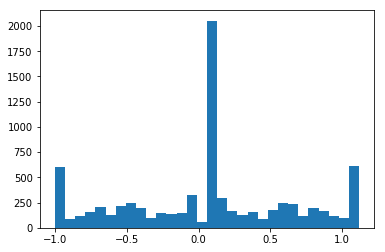

In [23]:
plt.hist(angle_labels, bins=30)
plt.show()

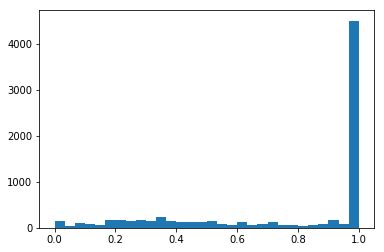

In [24]:
plt.hist(speed_labels, bins=30)
plt.show()

In [25]:
def rnn_lstm(seq_length=3, num_outputs=2, image_shape=(120,160,3)):

    img_seq_shape = (seq_length,) + image_shape   
    img_in = Input(batch_shape = img_seq_shape, name='img_in')
    
    x = Sequential()
    x.add(TD(Convolution2D(24, (5,5), strides=(2,2), activation='relu'), input_shape=img_seq_shape))
    x.add(TD(Convolution2D(32, (5,5), strides=(2,2), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(2,2), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(1,1), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(1,1), activation='relu')))
    x.add(TD(Flatten(name='flattened')))
    x.add(TD(Dense(100, activation='relu')))
    x.add(TD(Dropout(.1)))
      
    x.add(LSTM(128, return_sequences=True, name="LSTM_seq"))
    x.add(Dropout(.1))
    x.add(LSTM(128, return_sequences=False, name="LSTM_out"))
    x.add(Dropout(.1))
    x.add(Dense(50, activation='relu'))
    x.add(Dropout(.1))
    x.add(Dense(num_outputs, activation='linear', name='model_outputs'))
    
    x.compile(optimizer='adam',
                  loss={'model_outputs' : 'mean_squared_error'})
    
    print(x.summary())

    return x

In [53]:
model = rnn_lstm()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, 3, 58, 78, 24)     1824      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 3, 27, 37, 32)     19232     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 3, 13, 18, 64)     18496     
_________________________________________________________________
time_distributed_28 (TimeDis (None, 3, 11, 16, 64)     36928     
_________________________________________________________________
time_distributed_29 (TimeDis (None, 3, 9, 14, 64)      36928     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 3, 8064)           0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 3, 100)            806500    
__________

In [54]:
model_path = os.path.abspath("models/lstm_model.h5")
checkpointer = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit_generator(generator=gen_train,
                           validation_data=gen_test,
                           steps_per_epoch=(sep_train / BATCH_SIZE),
                           validation_steps=(sep_test / BATCH_SIZE),
                           epochs=10,
                           shuffle=False,
                           callbacks=[checkpointer])

Epoch 1/10
387/386 [==============================] - 142s 367ms/step - loss: 0.1799 - val_loss: 0.2236
Epoch 2/10
387/386 [==============================] - 62s 161ms/step - loss: 9.2028e-04 - val_loss: 3.2939e-07
Epoch 3/10
387/386 [==============================] - 58s 150ms/step - loss: 2.2616e-05 - val_loss: 1.1401e-06
Epoch 4/10
387/386 [==============================] - 58s 150ms/step - loss: 1.7288e-05 - val_loss: 7.3663e-07
Epoch 5/10
387/386 [==============================] - 59s 151ms/step - loss: 1.2778e-05 - val_loss: 2.9817e-07
Epoch 6/10
387/386 [==============================] - 59s 151ms/step - loss: 9.4556e-06 - val_loss: 7.4533e-08
Epoch 7/10
387/386 [==============================] - 59s 153ms/step - loss: 6.9164e-06 - val_loss: 2.0808e-07
Epoch 8/10
387/386 [==============================] - 58s 150ms/step - loss: 5.2404e-06 - val_loss: 1.4639e-06
Epoch 9/10
387/386 [==============================] - 60s 154ms/step - loss: 3.2439e-06 - val_loss: 2.8124e-07
Epoch 10

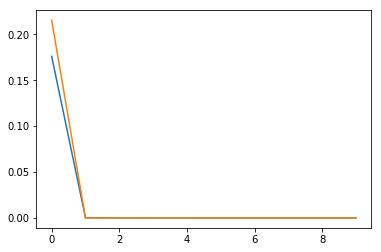

In [28]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()